<a href="https://colab.research.google.com/github/RaquelGrosman/BigD/blob/master/2.0_week2_loopVIDEO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# pip standard package manager for Python (inalll and manage additional packages that are not part of the Python standard library) 
# here calling the astroquery package
!pip install astroquery 

# For querying for data
from astroquery.mast import Tesscut, Observations, Catalogs

# For manipulating data
import numpy as np

# From a pacage in order to have functiond and methods to manipulate data
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.timeseries import LombScargle
from astropy.time import Time
import astropy.units as u

# For matplotlib plotting
import matplotlib
%matplotlib inline

# functions used for plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# For animation display
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')

# For bokeh plotting
from bokeh import plotting
from bokeh.models import Span
plotting.output_notebook()


# the two following lines are the only manual inputs of the code
tic_id = 233964642                               #planatary object with is being analyzed 
sector = 2  #represents the section of sky its observing; data collected 

tpeak = 2458341.89227 # Julian Day

#setting criteria of query, obtaining desired data
mission_res = Observations.query_criteria(obs_collection="TESS", 
                                          target_name=tic_id, 
                                          sequence_number=sector)
mission_res

tasoc_res = Observations.query_criteria(target_name=tic_id, 
                                        obs_collection="HLSP", 
                                        project="TESS",
                                        sequence_number=sector)
tasoc_res['dataproduct_type',"obs_collection","target_name","t_exptime","filters",
          "provenance_name","project","sequence_number","instrument_name"]

tasoc_prod = Observations.get_product_list(tasoc_res)
tasoc_prod["dataproduct_type", "description", "dataURI", "size"]

tasoc_manifest = Observations.download_products(tasoc_prod)
tasoc_manifest

# Loading the short cadence light curve
hdu = fits.open(tasoc_manifest["Local Path"][0])
short_cad_lc = Table(hdu[1].data)
hdu.close()

# Loading the long cadence light curve
hdu = fits.open(tasoc_manifest["Local Path"][0])
long_cad_lc = Table(hdu[1].data)
hdu.close()

#setting size and name to the plotted graph
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{tic_id})") #the axes do not show, attempted to ochange groph size and axes labeling, but it still did not work

# Short cadence
bfig.circle(short_cad_lc["TIME"],short_cad_lc["FLUX_RAW"], fill_color="black",size=2, line_color=None)
bfig.line(short_cad_lc["TIME"],short_cad_lc["FLUX_RAW"], line_color='black')

# Long cadence
bfig.circle(long_cad_lc["TIME"],long_cad_lc["FLUX_RAW"], fill_color="#0384f7",size=6, line_color=None)
bfig.line(long_cad_lc["TIME"],long_cad_lc["FLUX_RAW"], line_color='#0384f7')


# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

#calling methods to obtain data desired and pot (make table) adequetly
coord = Observations.resolve_object(f"TIC {tic_id}")
cutout_hdu = Tesscut.get_cutouts(coordinates=coord, size=40, sector=1)[0]
cutout_hdu.info()
cutout_table = Table(cutout_hdu[1].data)
cutout_table.columns

start_btjd = 1341.5 #start time in plot
end_btjd = 1342.5 #end time in plat with a total of 48 frames

start_index = (np.abs(cutout_table['TIME'] - start_btjd)).argmin() 
end_index = (np.abs(cutout_table['TIME'] - end_btjd)).argmin()

#print the number of frames in plot
print(f"Frames {start_index}-{end_index} ({end_index-start_index} frames)")

#GIf code; sets the paramets of time and retreiving images
def make_animation(data_array, start_frame=0, end_frame=None, vmin=None, vmax=None, delay=50):
    """
    Function that takes an array where each frame is a 2D image array and make an animated plot
    that runs through the frames.
    
    Note: This can take a long time to run if you have a lot of frames.    
    Parameters
    ----------
    data_array : array
        Array of 2D images.
    start_frame : int
        The index of the initial frame to show. Default is the first frame.
    end_frame : int
        The index of the final frame to show. Default is the last frame.
    vmin : float
        Data range min for the colormap. Defaults to data minimum value.
    vmax : float
        Data range max for the colormap. Defaults to data maximum value.
    delay: 
        Delay before the next frame is shown in milliseconds.

    Returns
    -------
    response : `animation.FuncAnimation`
    """
    
    if not vmin:
        vmin = np.min(data_array)
    if not vmax:
        vmax = np.max(data_array)
        
    if not end_frame:
        end_frame = len(data_array) - 1 # set to the end of the array
        
    num_frames = end_frame - start_frame + 1 # include the end frame
        
    def animate(i, fig, ax, binarytab, start=0):
        """Function used to update the animation"""
        ax.set_title("Epoch #" + str(i+start))
        im = ax.imshow(binarytab[i+start], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)
        return im,
    
    # Create initial plot.
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(data_array[start_frame], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)

    #initialize animation, now as a complete visual
    ani = animation.FuncAnimation(fig, animate, fargs=(fig, ax, data_array, start_frame), frames=num_frames, 
                                  interval=delay, repeat_delay=1000)

    plt.close()
    
    return ani

#populates the amimation 
make_animation(cutout_table['FLUX'], start_index, end_index, vmax=700, delay=150)

INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00233964642-s02-c1800_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00233964642-s02-c1800_tess_v04_lc.fits with expected size 158400. [astroquery.query]


Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 1600J, 1600E, 1600E, 1600E, 1600E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (40, 40)   int32   
Frames 721-769 (48 frames)


Number of sources: 9
    ID           ra               dec        ... wdflag     dstArcSec     
--------- ---------------- ----------------- ... ------ ------------------
233964642 36.4987501368371 -63.6475472217311 ...      0                0.0
233964635  36.454617845949 -63.6235314595086 ...      0 111.59117291844485
233965575 36.6350784874392 -63.6040739033097 ...      0  268.3776399762906
233964615 36.4502456898505 -63.5472928394423 ...      0  369.1738147983141
233964616 36.4133300171616 -63.5507447136406 ...      0 374.35409537315996
233964607 36.5743041445554 -63.5236550574102 ...      0 462.13344781260867
233965546  36.750047139831 -63.7372799096175 ...      0  514.8842384527876
233965591 36.7805739697842 -63.5525901254581 ...      0   566.001916081705
382583300 36.3138364880159 -63.5097516009179 ...      0  577.7716260733699


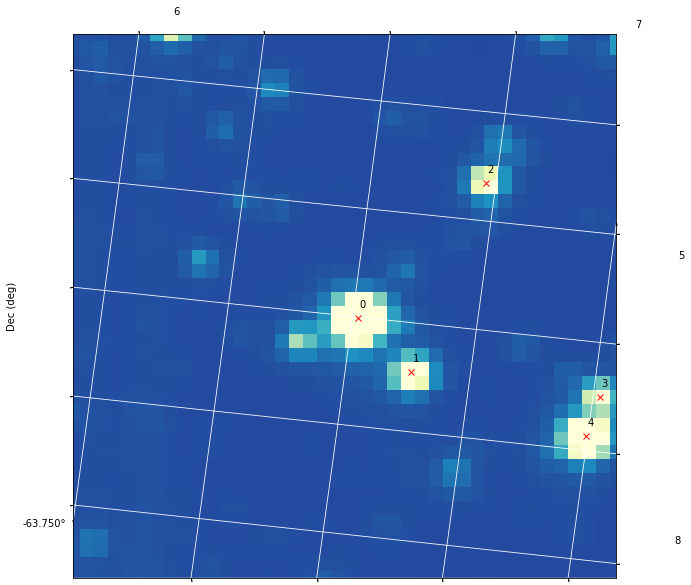

Number of tasoc light curves for 233964635: 1

INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00233964635-s02-c1800_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00233964635-s02-c1800_tess_v04_lc.fits with expected size 158400. [astroquery.query]


In [10]:
# initializinf new variables to call and create new image and graphs
sources = Catalogs.query_object(catalog="TIC", objectname=f"TIC {tic_id}", radius=10*u.arcmin)
sources = sources[sources["Tmag"] < 12]
print(f"Number of sources: {len(sources)}") #printing number of sources
print(sources)

cutout_wcs = WCS(cutout_hdu[2].header) #world coordinate sytem - picking which ones
cutout_img = cutout_table["FLUX"][start_index] 

fig, ax = plt.subplots(subplot_kw={'projection':cutout_wcs})
fig.set_size_inches(10,10)
plt.grid(color='white', ls='solid')
    
# Setup WCS axes.
xcoords = ax.coords[0]
ycoords = ax.coords[1]
xcoords.set_major_formatter('d.ddd')
ycoords.set_major_formatter('d.ddd')
xcoords.set_axislabel("RA (deg)")
ycoords.set_axislabel("Dec (deg)")
ax.imshow(cutout_img, cmap=plt.cm.YlGnBu_r,vmin=0,vmax=700)
ax.plot(sources['ra'],sources['dec'],'x',transform=ax.get_transform('icrs'),color="red")

# Annotating the sources with their row nnumber in the sources table
for i,star in enumerate(sources):
    ax.text(star['ra']+0.01,star['dec'],i,transform=ax.get_transform('icrs'))

ax.set_xlim(0,cutout_img.shape[1]-1)
ax.set_ylim(cutout_img.shape[0]-1,0)

plt.show()

# initializinf variable, to be called 
sources["ID","ra","dec"][0]
variable_tic_id = sources["ID"][1]
variable_res = Observations.query_criteria(target_name=variable_tic_id, 
                                        obs_collection="HLSP", 
                                        filters="TESS")
print(f"Number of tasoc light curves for {variable_tic_id}: {len(variable_res)}\n")

        
variable_prod = Observations.get_product_list(variable_res[0])
variable_manifest = Observations.download_products(variable_prod)

hdu = fits.open(variable_manifest["Local Path"][0])
variable_lc = Table(hdu[1].data)
hdu.close()

bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{variable_tic_id})")

bfig.circle(variable_lc["TIME"],variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)
bfig.line(variable_lc["TIME"],variable_lc["FLUX_RAW"], line_color='black')

# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)


# dominant_freq = frequency[np.argmax(power)].value
# print(f"The dominant priod: {1/dominant_freq*24:.3} hours")

# bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Phased Lightcurve (TIC{variable_tic_id})")

# # Plotting the phased light curve
# bfig.circle(variable_lc["TIME"]%(1/dominant_freq),variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)

# # Plotting the periodic fit
# t_fit = np.linspace(0,1/dominant_freq,100)
# bfig.line(t_fit, lomb.model(t_fit, dominant_freq), color='#1b9f00', line_width=2)

# # Labeling the axes
# bfig.xaxis.axis_label = "Phase (days)"
# bfig.yaxis.axis_label = "Flux"

# plotting.show(bfig)